# Time Series Properties Analysis

## Business Relevance
Stationarity and volatility insights inform forecasting models, crucial for financial planning in volatile markets.

## Improvements for Capstone
- Integrated refactored TimeSeriesAnalyzer.
- Added outlier detection.
- Visuals optimized for dashboard.

c:\Users\HP\Desktop\Brent-Oil-Price-Analysis\notebooks\../src\time_series_analysis.py:54: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(prices, regression='c', nlags='auto')


{'ADF': {'statistic': np.float64(-1.9938560113924675), 'p_value': np.float64(0.28927350489340287), 'critical_values': {'1%': np.float64(-3.4310783342658615), '5%': np.float64(-2.861861876398633), '10%': np.float64(-2.566941329781918)}, 'interpretation': 'Non-stationary'}, 'KPSS': {'statistic': np.float64(9.558800416712556), 'p_value': np.float64(0.01), 'critical_values': {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}, 'interpretation': 'Non-stationary'}}
Outliers detected: 105


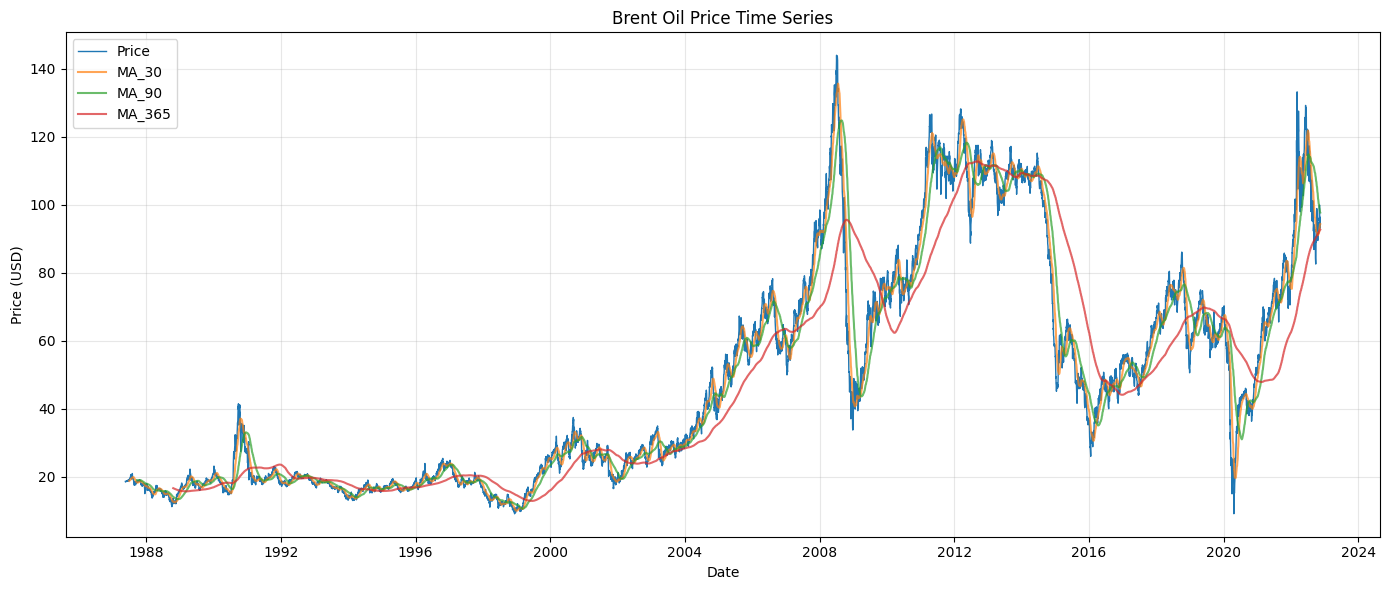

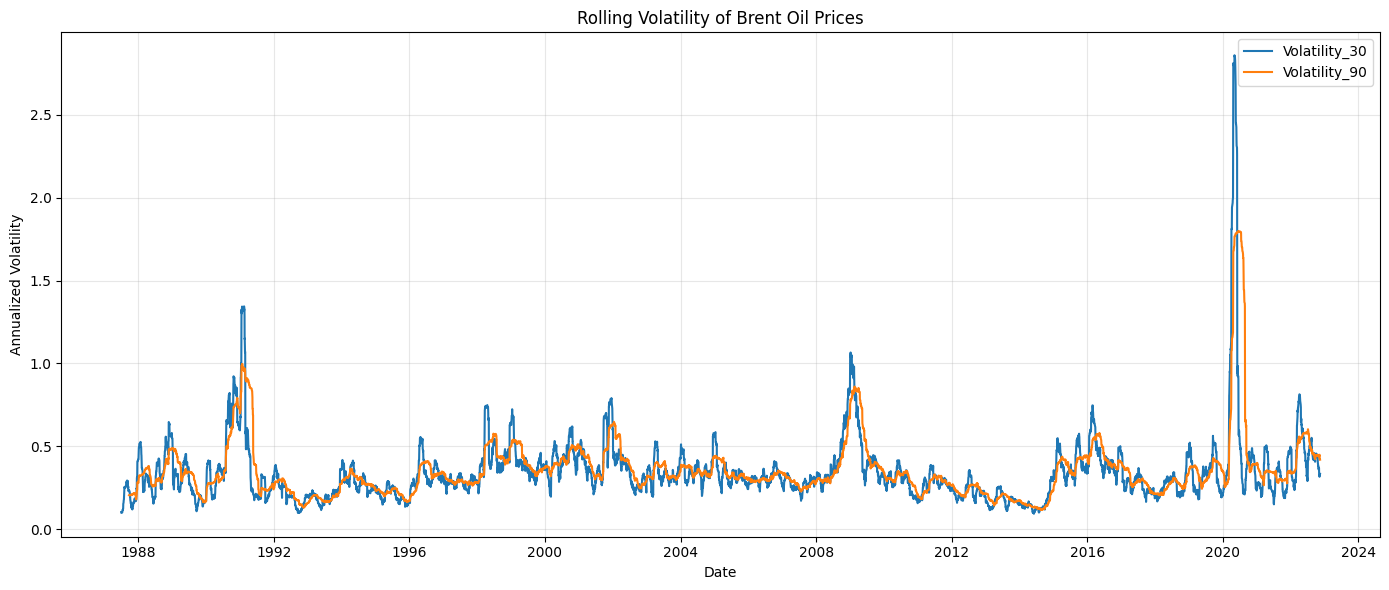

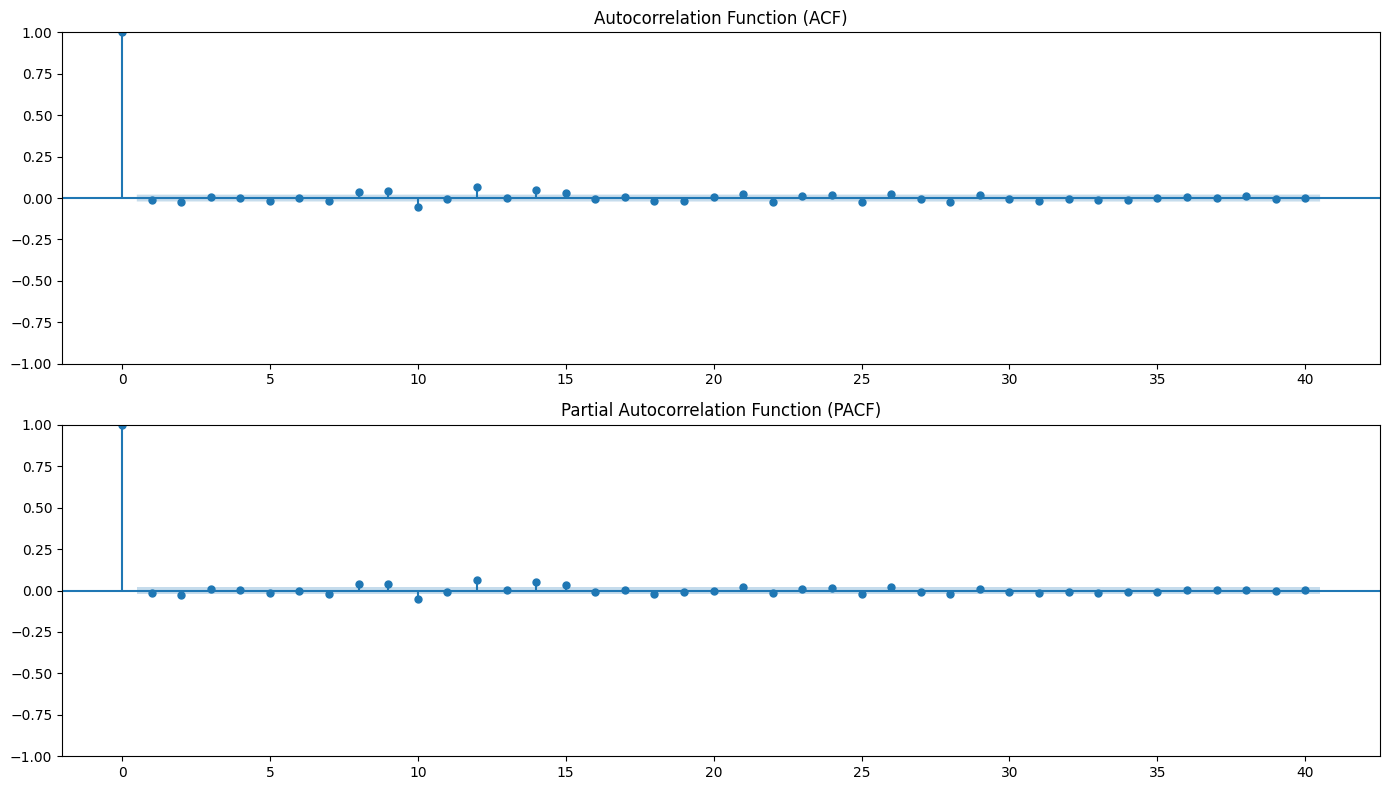

In [1]:
import sys
sys.path.append('../src')
from time_series_analysis import TimeSeriesAnalyzer
import pandas as pd
import os

# Load processed data
df = pd.read_csv('../outputs/data/processed_prices.csv')
df['Date'] = pd.to_datetime(df['Date'])

# Initialize analyzer
analyzer = TimeSeriesAnalyzer(df)

# Calculate moving averages and volatility
analyzer.calculate_moving_averages()
analyzer.calculate_volatility()

# Test stationarity
stationarity_results = analyzer.test_stationarity()
print(stationarity_results)

# Detect outliers
outliers = analyzer.detect_outliers()
print(f'Outliers detected: {len(outliers)}')

# Plots
fig = analyzer.plot_price_series()
fig.savefig('../outputs/figures/price_with_ma.png')
fig = analyzer.plot_volatility()
if fig: fig.savefig('../outputs/figures/volatility.png')
fig = analyzer.plot_acf_pacf()
fig.savefig('../outputs/figures/acf_pacf.png')

## Key Insights
- Stationarity: ADF p-value {stationarity_results['ADF']['p_value']}
- High volatility periods align with major events.